In [4]:
# Variational Graph Auto-Encoder implementation for fMRI time series discimination (real vs. synthetic)

# Anish Kochhar, Imperial College London, May 2025

In [126]:
from wbm.data_loader import BOLDDataLoader
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

import os, random, contextlib
from typing import List
from pathlib import Path
from copy import deepcopy
from sklearn.covariance import LedoitWolf
from sklearn.decomposition import PCA
from torch_geometric.utils import dense_to_sparse, negative_sampling, to_dense_adj
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, VGAE, global_mean_pool
from torch_geometric.nn.models.autoencoder import InnerProductDecoder
from torch_geometric.loader import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm


In [78]:
class GraphBuilder:
    """
    Converts (bold, sc) pairs into PyG Data objects:
        adjacenct = structural connectivity (N, N)
        x = Ledoit-Wolf FC column featrures (N, N) 
            (+ optional PCA of raw BOLD) (N, p_dim)
        y = label (1 = real, 0 = synthetic)
    """
    def __init__(self, node_dim: int = 100, pca_dim: int = 8, use_pca: bool = True, device: str = "cpu"):
        self.node_dim = node_dim
        self.pca_dim = pca_dim
        self.use_pca = use_pca
        self.device = device
        self._pca = PCA(n_components=pca_dim) if use_pca else None

    @staticmethod
    def _ledoit_wolf_corr(bold_np: np.ndarray):
        """ 
        Ledoit-Wold shrunk covariance, used as correlation column features 
        Parameters:
            bold_np: shape (N, T)
        """
        lw = LedoitWolf(store_precision=False).fit(bold_np.T)
        covariance = lw.covariance_
        std = np.sqrt(np.diag(covariance) + 1e-12)
        correlation = covariance / np.outer(std, std) # shape (N, N)
        return correlation 
    
    def _node_features(self, bold_np: np.ndarray):
        """
        Feature 1: column of shrunk FC (N, N)
        Feature 2: p PCA components (N, p)
        """
        fc = self._ledoit_wolf_corr(bold_np)
        feats = [fc.T] # x_i columns
        if self.use_pca:
            pca_feats = self._pca.fit_transform(bold_np)
            feats.append(pca_feats)
        feat_mat = np.concatenate(feats, axis=1)      # (N, d)
        return torch.tensor(feat_mat, dtype=torch.float32, device=self.device)
    
    def build_graph(self, bold: np.ndarray, sc: np.ndarray, label: int):
        """
        Parameters:
            bold: ndarray, BOLD chunk with shape (N, T)
            sc: ndarray, SC matrix ([0, 1] normalised) shape (N, N)
            label: int, 1 = real, 0 = simualted
        """
        sc = sc / sc.max() # Normalise
        sc = np.log1p(sc)
        np.fill_diagonal(sc, 0.0)
        A = torch.tensor(sc, dtype=torch.float32)
        X = self._node_features(bold)
        edge_index, edge_weight = dense_to_sparse(A)
        data = Data(x = X, edge_index=edge_index.long(), edge_weight=edge_weight, y=torch.tensor([label], dtype=torch.float32))
        return data


In [133]:
import scipy.stats
from sklearn.manifold import TSNE

def visualize_reconstruction(z, data, encoder, device="cuda"):
    encoder.eval()
    data = data.to(device)

    with torch.no_grad():
        preds = encoder.decoder(z, data.edge_index, sigmoid=False)

        edge_mean = data.edge_weight.mean()
        edge_std = data.edge_weight.std() + 1e-6
        preds_rescaled = preds * edge_std + edge_mean # Rescale to ground truth scale

        A_true = to_dense_adj(data.edge_index, edge_attr=data.edge_weight)[0].cpu().numpy()
        A_pred = to_dense_adj(data.edge_index, edge_attr=preds_rescaled)[0].cpu().numpy()

        # Flatten upper triangle for correlation stats
        triu_indices = np.triu_indices_from(A_true, k=1)
        true_vals = A_true[triu_indices]
        pred_vals = A_pred[triu_indices]

        mse = np.mean((pred_vals - true_vals) ** 2)
        pearson = scipy.stats.pearsonr(pred_vals, true_vals)[0]
        spearman = scipy.stats.spearmanr(pred_vals, true_vals)[0]

        print(f"[Epoch Stats] Pred mean: {pred_vals.mean():.4f} | min: {pred_vals.min():.4f} | max: {pred_vals.max():.4f}")
        print(f"[Epoch Stats] True mean: {true_vals.mean():.4f} | min: {true_vals.min():.4f} | max: {true_vals.max():.4f}")
        print(f"[Epoch Stats] Pearson Corr: {pearson:.4f} | Spearman Corr: {spearman:.4f}")
        print(f"[Epoch Stats] MSE (dense): {mse:.6f}")
        print(f"[Epoch Stats] Diagonal Pred Mean: {np.diag(A_pred).mean():.4f}")


        fig, axs = plt.subplots(1, 2, figsize=(12, 5))
        im0 = axs[0].imshow(A_true, cmap="viridis", vmin=0, vmax=1)
        axs[0].set_title("True Adjacency (Weighted)")
        plt.colorbar(im0, ax=axs[0])

        im1 = axs[1].imshow(A_pred, cmap="viridis", vmin=0, vmax=1)
        axs[1].set_title("Reconstructed Adjacency")
        plt.colorbar(im1, ax=axs[1])

        plt.tight_layout()
        plt.show()

    encoder.train()

def plot_tsne(discriminator, dataset, device="cuda"):
    discriminator = discriminator.to(device)
    discriminator.eval()

    z_list = []
    labels = []

    for data in dataset:
        data = data.to(device)
        with torch.no_grad():
            z = discriminator.encoder.encode(data.x, data.edge_index, data.edge_weight)
            z_graph = z.mean(dim=0).cpu().numpy()
            z_list.append(z_graph)
            labels.append(data.y.item())
        
    z_array = np.vstack(z_list)
    labels = np.array(labels)

    tsne = TSNE(n_components=2, perplexity=30, learning_rate='auto', init='random')
    z_2d = tsne.fit_transform(z_array)

    plt.figure(figsize=(8, 6))
    plt.scatter(z_2d[labels == 0, 0], z_2d[labels == 0, 1], label="Fake", alpha=0.6, marker='x')
    plt.scatter(z_2d[labels == 1, 0], z_2d[labels == 1, 1], label="Real", alpha=0.6, marker='o')
    plt.legend()
    plt.title("t-SNE of Graph-Level Latent Embeddings")
    plt.xlabel("TSNE-1")
    plt.ylabel("TSNE-2")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [123]:
# Encoder
class _GCNEncoder(nn.Module):
    def __init__(self, in_dim, hidden, latent):
        super().__init__()
        self.conv1 = GCNConv(in_dim, hidden)
        self.conv_mu = GCNConv(hidden, latent)
        self.conv_logvar = GCNConv(hidden, latent)

    def forward(self, x, edge_index, edge_weight):
        h = F.relu(self.conv1(x, edge_index, edge_weight))
        return self.conv_mu(h, edge_index, edge_weight), self.conv_logvar(h, edge_index, edge_weight)
    
class MLPDecoder(nn.Module):            # Weighted edge prediction decoder
    def __init__(self, latent_dim):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(latent_dim * 4, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, z, edge_index, sigmoid: bool = False):
        z_i = z[edge_index[0]]
        z_j = z[edge_index[1]]
        # edge_input = torch.cat([z_i, z_j], dim=1)
        edge_input = torch.cat([z_i, z_j, z_i - z_j, z_i * z_j], dim=1) # Learn more asymmetic and interaction-aware relationships
        out = self.mlp(edge_input).squeeze()
        return torch.sigmoid(out) if sigmoid else out


# Subclass VGAE
class FixedVGAE(VGAE):
    def __init__(self, encoder, latent_dim):
        super().__init__(encoder, decoder=MLPDecoder(latent_dim))

    # def encode(self, x, edge_index, edge_weight):
    #     return super().encode(x, edge_index, edge_weight)


    def kl_loss(self, reduction: str = 'mean'):
        mu, logstd = self.__mu__, self.__logstd__
        kl = -0.5 * torch.sum(1 + 2 * logstd - mu.pow(2) - (2 * logstd).exp(), dim=1)
        return kl.sum() if reduction == 'sum' else kl.mean()

    def recon_loss(self, z, pos_edge_index, edge_weight, neg_edge_index=None):
        pos_edge_index = pos_edge_index.to(z.device).long()
        edge_weight = edge_weight.to(z.device)

        # Standarise edge weights
        mean = edge_weight.mean()
        std = edge_weight.std() + 1e-6
        norm_weights = (edge_weight - mean) / std

        # Predict positive edges
        pred_pos = self.decoder(z, pos_edge_index, sigmoid=False)
        pos_loss = F.smooth_l1_loss(pred_pos, norm_weights)

        # Predict on negative edges (assumed weight = 0)
        if neg_edge_index is None:
            neg_edge_index = negative_sampling(pos_edge_index, z.size(0))
        neg_edge_index = neg_edge_index.to(z.device).long()

        pred_neg = self.decoder(z, neg_edge_index, sigmoid=False)
        neg_loss = F.smooth_l1_loss(pred_neg, torch.zeros_like(pred_neg))

        return pos_loss + neg_loss

# VGAE
def build_vgae(in_dim, hidden = 64, latent = 32):
    encoder = _GCNEncoder(in_dim, hidden, latent)
    return FixedVGAE(encoder, latent_dim=latent)

# Classifier Head
class GraphClassifier(nn.Module):
    def __init__(self, latent_dim=32):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 1)
        )

    def forward(self, z):
        logits = self.mlp(z)
        return torch.sigmoid(logits)

In [135]:
   
class DiscriminatorVGAE(nn.Module):
    """
    Wrapper that includes:
        VGAE encoder (frozen after pre-trian unless unfreeze = True)
        Graph-level MLP classifier
        helper exposing get_lost(real_graphs, simulated_graphs), returning a scalar loss
    """
    def __init__(self, encoder: VGAE, latent_dim: int = 32):
        super().__init__()
        self.encoder = encoder
        self.classifier = GraphClassifier(latent_dim)


    def encode(self, data: Data):
        """ Returs node-level latents (requires grad = False) """
        with torch.no_grad():
            z_nodes = self.encoder.encode(data.x, data.edge_index, data.edge_weight)
        return z_nodes
    
    def forward(self, data: Data):
        z = self.encode(data).mean(dim=0, keepdim=True) # (batch_size, latent)
        z_graph = global_mean_pool(z, data.batch) # graph-wise latent summary
        confidence = self.classifier(z_graph)
        return confidence


    # MARK: Unsupervised VGAE Training 
    @staticmethod
    def train_unsupervised(encoder: VGAE, dataset: List[Data], epochs: int = 200, beta: float = 1e-3, 
                           batch_size: int = 16, lr: float = 1e-3, device: str = "cuda", verbose: bool = True,
                           warmup_epochs: int = 50):
        loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
        encoder = encoder.to(device)
        optimizer = torch.optim.Adam(encoder.parameters(), lr=lr)

        pbar = tqdm(range(epochs), "VGAE pre-train")
        losses, kl_losses, recon_losses = [], [], []

        for epoch in pbar:
            epoch_loss = epoch_kl_loss = epoch_recon_loss = 0.0
            beta_scaled = beta * min(1.0, epoch / warmup_epochs)

            for data in loader:
                data = data.to(device)
                optimizer.zero_grad()

                z = encoder.encode(data.x, data.edge_index, data.edge_weight)
                recon = encoder.recon_loss(z, data.edge_index, data.edge_weight)
                kl = encoder.kl_loss(reduction = 'sum') / data.num_nodes

                loss = recon + beta_scaled * kl
                loss.backward()
                optimizer.step()

                epoch_loss += loss.item()
                epoch_kl_loss += kl.item()
                epoch_recon_loss += recon.item()
            
            kl_losses.append(epoch_kl_loss / len(loader))
            recon_losses.append(epoch_recon_loss / len(loader))
            losses.append(epoch_loss / len(loader))

            pbar.set_postfix(loss=f"{epoch_loss / len(loader):.4f}")

            if epoch % 20 == 0 and verbose:
                with torch.no_grad():
                    print(f"Recon Loss: {recon.item():.4f}, KL Loss: {kl:.4f}")

                    sample = deepcopy(random.choice(dataset)).to(device)
                    z = encoder.encode(sample.x, sample.edge_index, sample.edge_weight)
                    print(f"[Latent] z mean: {z.mean().item():.4f} | std: {z.std().item():.4f}")

                    visualize_reconstruction(z, sample, encoder, device=device)
        
        if verbose:
            plt.figure(figsize=(8, 5))
            epochs_arr = range(epochs)
            plt.title("Loss values over time")
            plt.plot(epochs_arr, kl_losses, label="KL Loss")
            plt.plot(epochs_arr, recon_losses, label="Recon Loss")
            plt.plot(epochs_arr, losses, label="Total Loss")
            plt.xlabel("Epoch")
            plt.ylabel("Loss")
            plt.legend()
            plt.tight_layout()
            plt.show()

        print("[VGAE] Frozen training")

        # Freeze weights
        for p in encoder.parameters():
            p.requires_grad = False
        encoder.eval()


    # MARK: Supervised Classifier + VGAE Training
    @staticmethod
    def train_classifier(discriminator, dataset: List[Data], epochs: int = 50, batch_size: int = 8, lr: float = 1e-3,
                         device: str = "cuda", freeze_encoder: bool = True):
        loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
        discriminator = discriminator.to(device)

        for param in discriminator.encoder.parameters():
            param.requires_grad = not freeze_encoder
            
        criterion = nn.BCELoss()
        if freeze_encoder:
            optimizer = torch.optim.Adam(discriminator.classifier.parameters(), lr=lr)
        else:
            optimizer = torch.optim.Adam(discriminator.parameters(), lr=lr)  # encoder + classifier


        pbar = tqdm(range(epochs), "Classifier train")
        losses = []

        for epoch in pbar:
            epoch_loss = 0.0
            correct, total = 0, 0

            for data in loader:
                data = data.to(device)
                batch = data.batch if hasattr(data, 'batch') else torch.zeros(data.x.size(0), dtype=torch.long, device=device)

                with torch.no_grad() if freeze_encoder else contextlib.nullcontext():
                    z = discriminator.encoder.encode(data.x, data.edge_index, data.edge_weight)
                
                z_graph = global_mean_pool(z, batch)  # [num_graphs, latent_dim]
                out = discriminator.classifier(z_graph).view(-1)

                target = data.y.float().to(device) 

                loss = criterion(out, target)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                epoch_loss += loss.item()
                preds = (out > 0.5).float()
                correct += (preds == target).sum().item()
                total += target.size(0)

            avg_loss = epoch_loss / len(loader)
            acc = correct / total
            losses.append(avg_loss)
            pbar.set_postfix(loss=f"{avg_loss:.4f}", acc=f"{acc:.2%}")

        return losses
    

    # Convenience function from WholeBrainModel
    def get_bce_loss(self, data_sim, device = "cuda"):
        """ Returns BCE loss w.r.t. label 1 (want to be real) """
        data_sim = data_sim.to(device)
        confidence = self(data_sim)
        target = torch.ones_like(confidence)
        return F.binary_cross_entropy(confidence, target)
    
    # Save + Load
    def save(self, checkpoint_path: str):
        Path(os.path.dirname(checkpoint_path)).mkdir(exist_ok=True, parents=True)
        torch.save(self.state_dict(), checkpoint_path)
    
    def load(self, checkpoint_path: str, map_location = "cpu"):
        self.load_state_dict(torch.load(checkpoint_path, map_location=map_location))

In [105]:
import matplotlib.pyplot as plt

def build_and_train_discriminator(real_graphs: List, simualated_graphs: List, figure_path = "", device = "cuda"):
    """
    real_graphs, simulated_graphs: Lists of PyG Data objects
    Returns ready-to-use DiscriminatorVGAE instance
    """

    in_dim = real_graphs[0].x.size(1)
    vgae = build_vgae(in_dim=in_dim, hidden=64, latent=32)

    # 1. Unsupervised pre-train
    DiscriminatorVGAE.train_unsupervised(vgae, real_graphs, device=device)

    # 2. Classifer
    discriminator = DiscriminatorVGAE(vgae, latent_dim=32)
    losses = DiscriminatorVGAE.train_classifier(discriminator, real_graphs + simualated_graphs, device=device)

    plt.plot(losses)
    plt.title("Classifier BCE")
    plt.show()
    
    return discriminator.to(device)

In [116]:

fmri_filename = "./HCP Data/BOLD Timeseries HCP.mat"
dti_filename = "./HCP Data/DTI Fibers HCP.mat"
distance_matrices_path = "./HCP Data/distance_matrices/"

device = "cuda"

data_loader = BOLDDataLoader(fmri_filename, dti_filename, distance_matrices_path, chunk_length=50)
builder = GraphBuilder(node_dim=data_loader.get_node_size(), pca_dim=8, use_pca=True, device="cuda")

real_dataset = data_loader.load_all_ground_truth(builder)

[DataLoader] Loaded 100 subjects.
[DataLoader] Created 2300 chunks (chunk length = 50).


In [112]:
node_size = data_loader.get_node_size()

# Completely synthetic data
def simulate_matching_chunks(num_chunks: int):
    chunks = []
    for _ in range(num_chunks):
        bold_fake = np.random.randn(node_size, 50)
        sc_fake   = np.random.rand(node_size, node_size)
        sc_fake   = (sc_fake + sc_fake.T) / 2
        chunks.append(builder.build_graph(bold_fake, sc_fake, label=0))
    return chunks

fake_dataset = simulate_matching_chunks(len(real_dataset))

Using in_dim = 108, hidden_dim = 64, latent_dim = 32


VGAE pre-train:   0%|          | 0/200 [00:05<?, ?it/s, loss=0.4543]

Recon Loss: 0.4546, KL Loss: 10.2300
[Latent] z mean: 0.0929 | std: 0.8561
[Epoch Stats] Pred mean: 0.0955 | min: 0.0000 | max: 0.4187
[Epoch Stats] True mean: 0.0942 | min: 0.0000 | max: 0.6931
[Epoch Stats] Pearson Corr: 0.9435 | Spearman Corr: 0.9796
[Epoch Stats] MSE (dense): 0.003610
[Epoch Stats] Diagonal Pred Mean: 0.0000


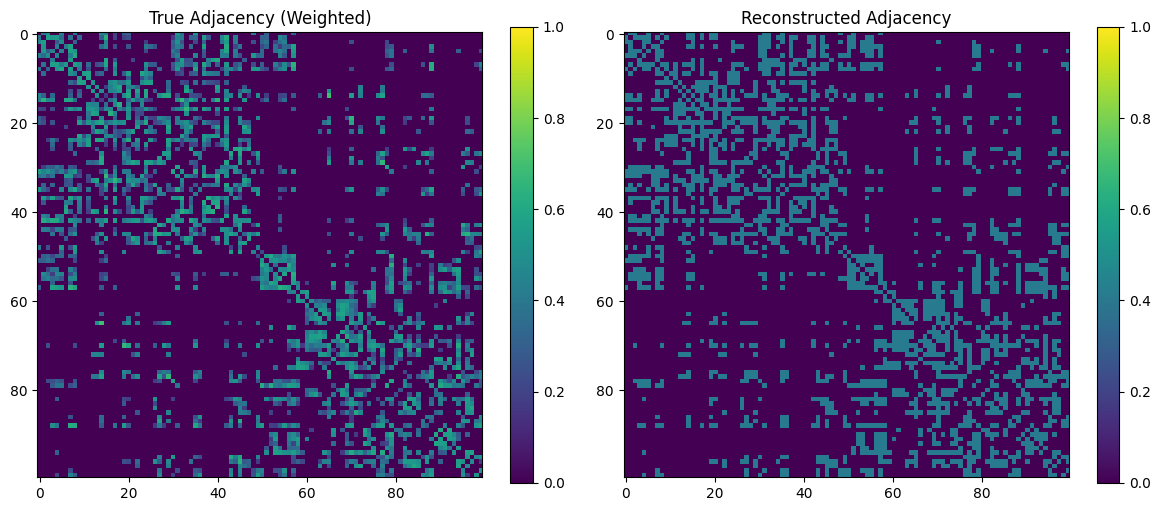

VGAE pre-train:  10%|█         | 20/200 [01:51<15:53,  5.29s/it, loss=0.4540]

Recon Loss: 0.4564, KL Loss: 0.0001
[Latent] z mean: 0.0072 | std: 1.0009
[Epoch Stats] Pred mean: 0.0915 | min: 0.0000 | max: 0.3980
[Epoch Stats] True mean: 0.0914 | min: 0.0000 | max: 0.6931
[Epoch Stats] Pearson Corr: 0.9464 | Spearman Corr: 0.9792
[Epoch Stats] MSE (dense): 0.003258
[Epoch Stats] Diagonal Pred Mean: 0.0000


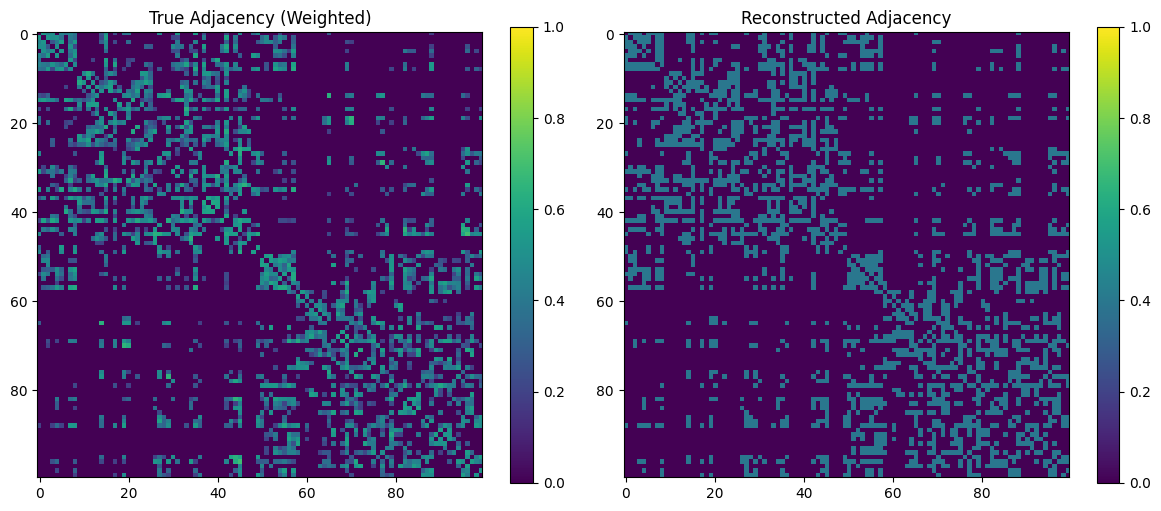

VGAE pre-train:  20%|██        | 40/200 [03:37<14:07,  5.30s/it, loss=0.4540]

Recon Loss: 0.4544, KL Loss: 0.0000
[Latent] z mean: -0.0067 | std: 0.9934
[Epoch Stats] Pred mean: 0.0980 | min: 0.0000 | max: 0.3962
[Epoch Stats] True mean: 0.0979 | min: 0.0000 | max: 0.6931
[Epoch Stats] Pearson Corr: 0.9456 | Spearman Corr: 0.9863
[Epoch Stats] MSE (dense): 0.003449
[Epoch Stats] Diagonal Pred Mean: 0.0000


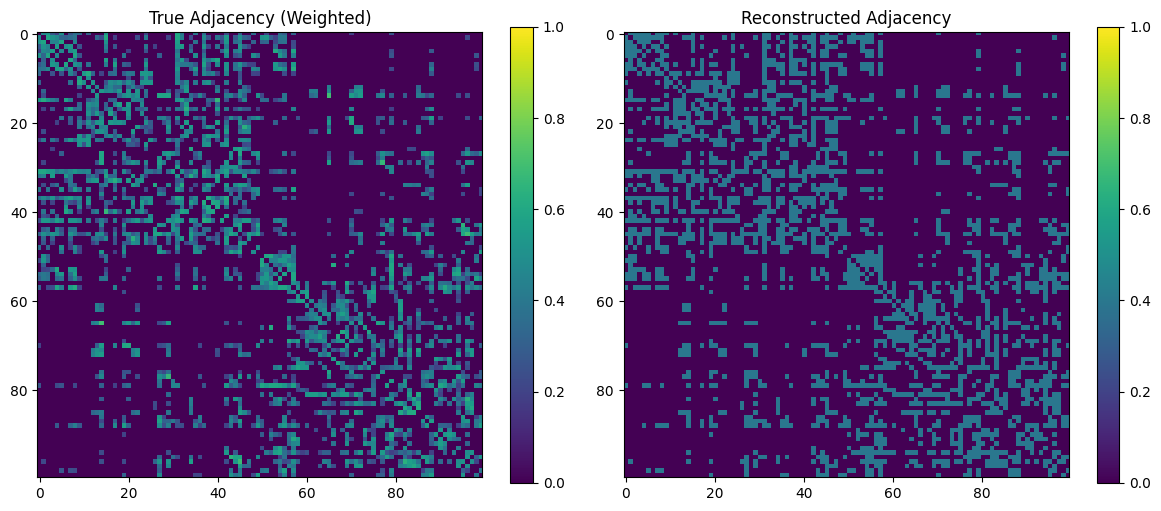

VGAE pre-train:  30%|███       | 60/200 [05:23<12:28,  5.35s/it, loss=0.4540]

Recon Loss: 0.4534, KL Loss: 0.0000
[Latent] z mean: -0.0075 | std: 0.9801
[Epoch Stats] Pred mean: 0.0916 | min: 0.0000 | max: 0.3982
[Epoch Stats] True mean: 0.0915 | min: 0.0000 | max: 0.6931
[Epoch Stats] Pearson Corr: 0.9495 | Spearman Corr: 0.9879
[Epoch Stats] MSE (dense): 0.003059
[Epoch Stats] Diagonal Pred Mean: 0.0000


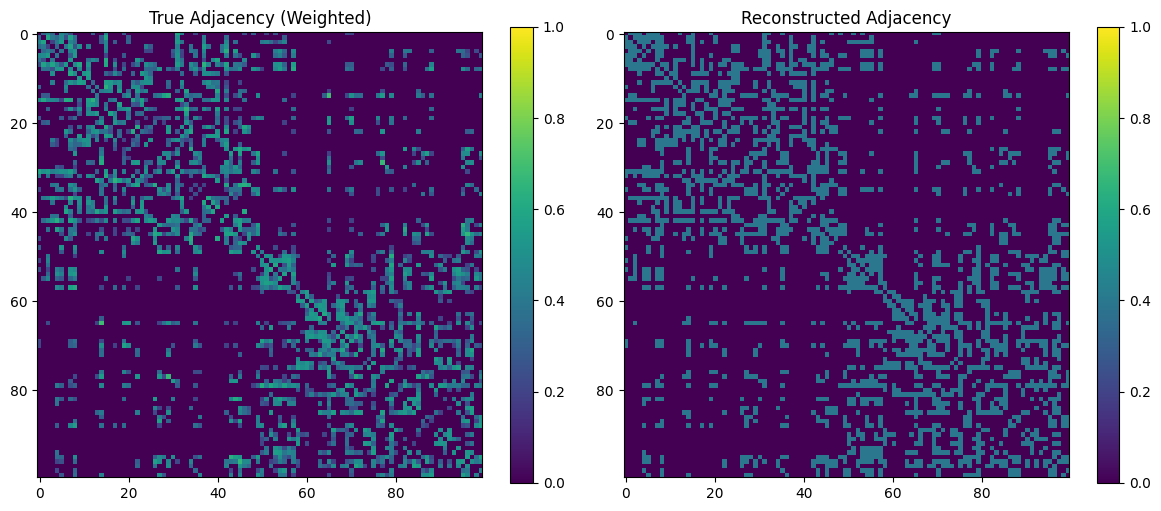

VGAE pre-train:  40%|████      | 80/200 [07:11<10:47,  5.40s/it, loss=0.4540]

Recon Loss: 0.4532, KL Loss: 0.0000
[Latent] z mean: -0.0205 | std: 0.9829
[Epoch Stats] Pred mean: 0.0866 | min: 0.0000 | max: 0.3938
[Epoch Stats] True mean: 0.0865 | min: 0.0000 | max: 0.6931
[Epoch Stats] Pearson Corr: 0.9625 | Spearman Corr: 0.9898
[Epoch Stats] MSE (dense): 0.002108
[Epoch Stats] Diagonal Pred Mean: 0.0000


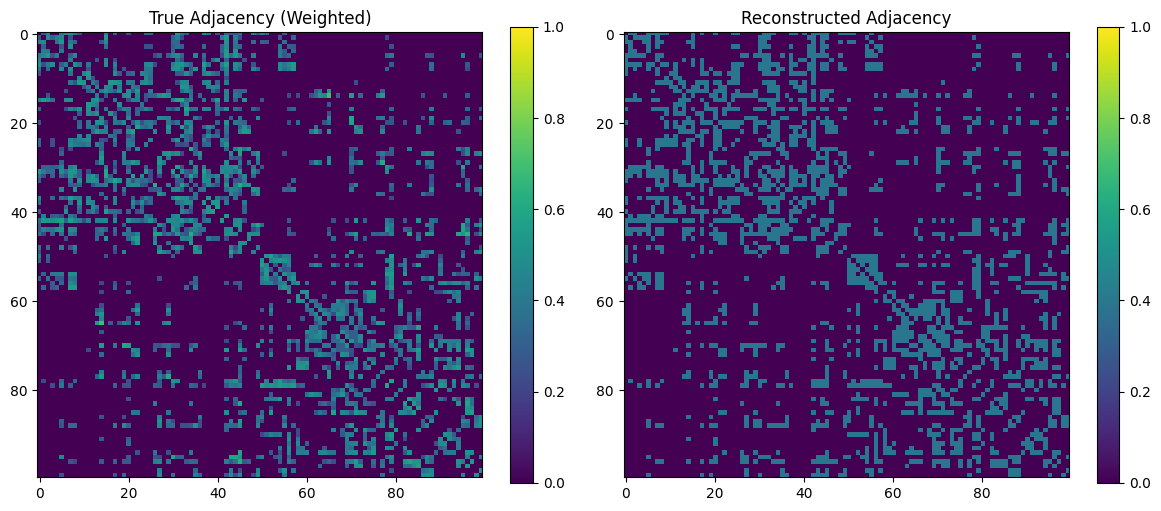

VGAE pre-train:  50%|█████     | 100/200 [08:57<08:50,  5.31s/it, loss=0.4540]

Recon Loss: 0.4526, KL Loss: 0.0000
[Latent] z mean: 0.0033 | std: 0.9879
[Epoch Stats] Pred mean: 0.0891 | min: 0.0000 | max: 0.4003
[Epoch Stats] True mean: 0.0890 | min: 0.0000 | max: 0.6931
[Epoch Stats] Pearson Corr: 0.9519 | Spearman Corr: 0.9895
[Epoch Stats] MSE (dense): 0.002863
[Epoch Stats] Diagonal Pred Mean: 0.0000


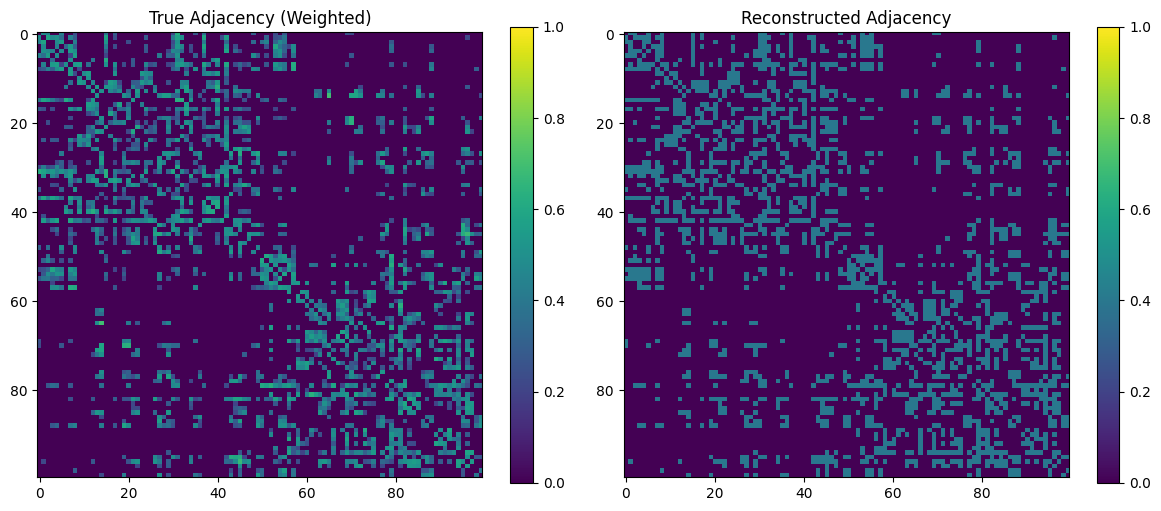

VGAE pre-train:  60%|██████    | 120/200 [10:43<07:00,  5.26s/it, loss=0.4540]

Recon Loss: 0.4553, KL Loss: 0.0000
[Latent] z mean: 0.0029 | std: 0.9957
[Epoch Stats] Pred mean: 0.0995 | min: 0.0000 | max: 0.3936
[Epoch Stats] True mean: 0.0993 | min: 0.0000 | max: 0.6931
[Epoch Stats] Pearson Corr: 0.9294 | Spearman Corr: 0.9861
[Epoch Stats] MSE (dense): 0.004600
[Epoch Stats] Diagonal Pred Mean: 0.0000


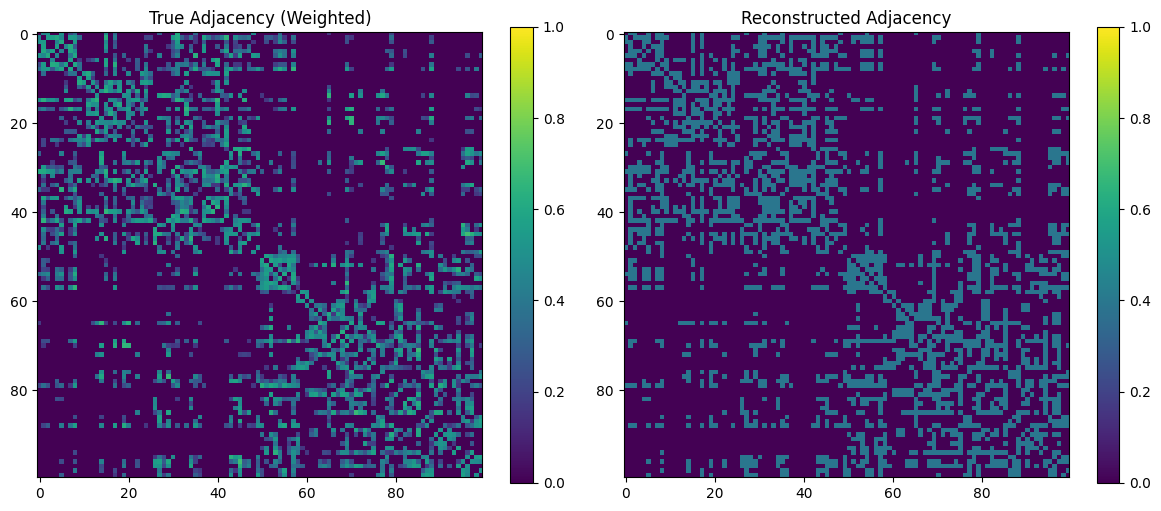

VGAE pre-train:  70%|███████   | 140/200 [12:29<05:18,  5.30s/it, loss=0.4540]

Recon Loss: 0.4535, KL Loss: 0.0000
[Latent] z mean: -0.0123 | std: 1.0040
[Epoch Stats] Pred mean: 0.1034 | min: 0.0000 | max: 0.3988
[Epoch Stats] True mean: 0.1032 | min: 0.0000 | max: 0.6931
[Epoch Stats] Pearson Corr: 0.9449 | Spearman Corr: 0.9852
[Epoch Stats] MSE (dense): 0.003654
[Epoch Stats] Diagonal Pred Mean: 0.0000


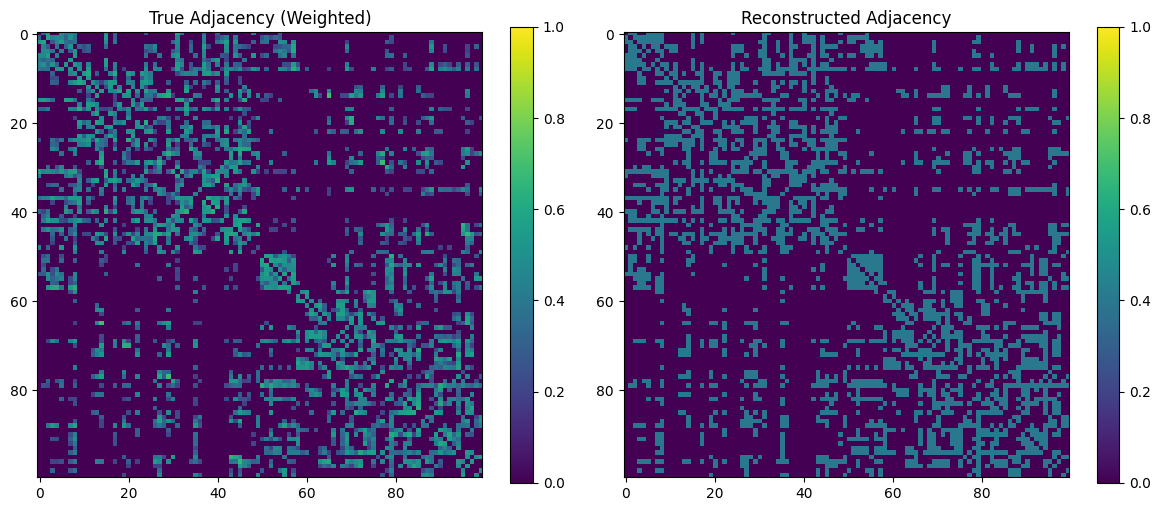

VGAE pre-train:  80%|████████  | 160/200 [14:15<03:31,  5.29s/it, loss=0.4540]

Recon Loss: 0.4543, KL Loss: 0.0000
[Latent] z mean: 0.0127 | std: 0.9922
[Epoch Stats] Pred mean: 0.0832 | min: 0.0000 | max: 0.3880
[Epoch Stats] True mean: 0.0830 | min: 0.0000 | max: 0.6931
[Epoch Stats] Pearson Corr: 0.9585 | Spearman Corr: 0.9904
[Epoch Stats] MSE (dense): 0.002237
[Epoch Stats] Diagonal Pred Mean: 0.0000


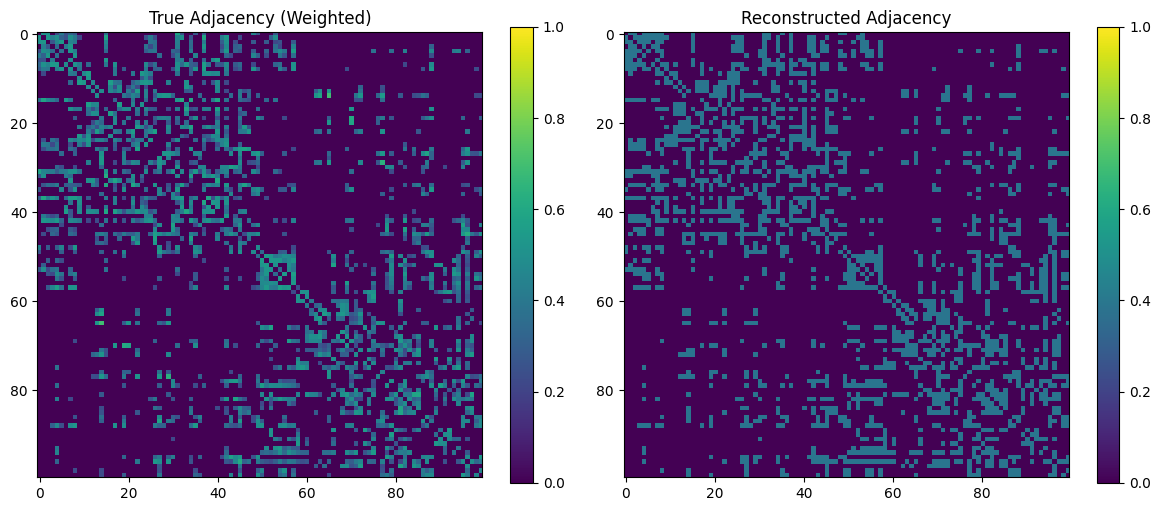

VGAE pre-train:  90%|█████████ | 180/200 [16:02<01:47,  5.39s/it, loss=0.4540]

Recon Loss: 0.4546, KL Loss: 0.0000
[Latent] z mean: 0.0154 | std: 0.9979
[Epoch Stats] Pred mean: 0.0888 | min: 0.0000 | max: 0.3960
[Epoch Stats] True mean: 0.0886 | min: 0.0000 | max: 0.6931
[Epoch Stats] Pearson Corr: 0.9573 | Spearman Corr: 0.9894
[Epoch Stats] MSE (dense): 0.002476
[Epoch Stats] Diagonal Pred Mean: 0.0000


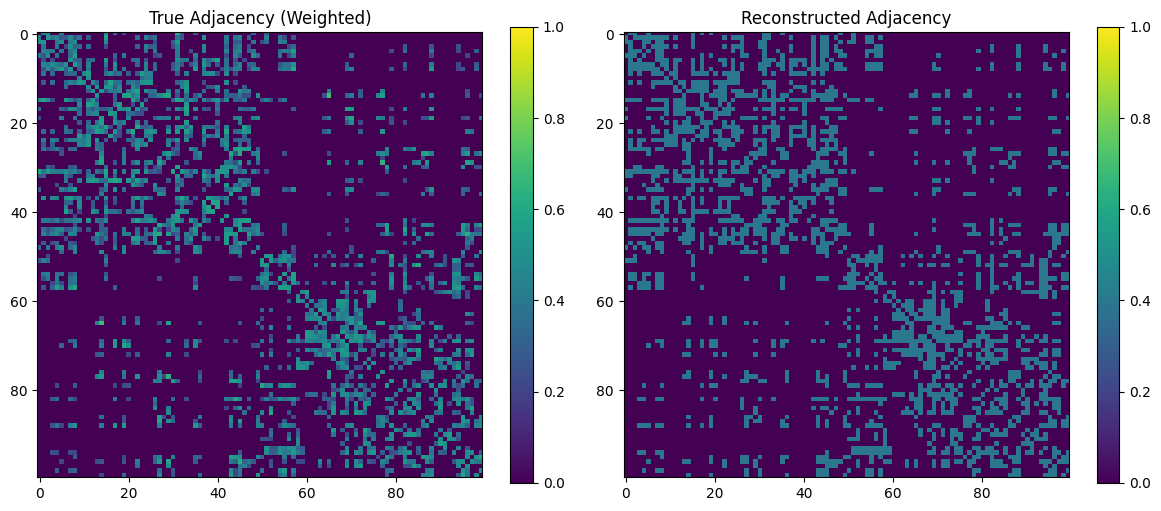

VGAE pre-train: 100%|██████████| 200/200 [17:43<00:00,  5.32s/it, loss=0.4540]


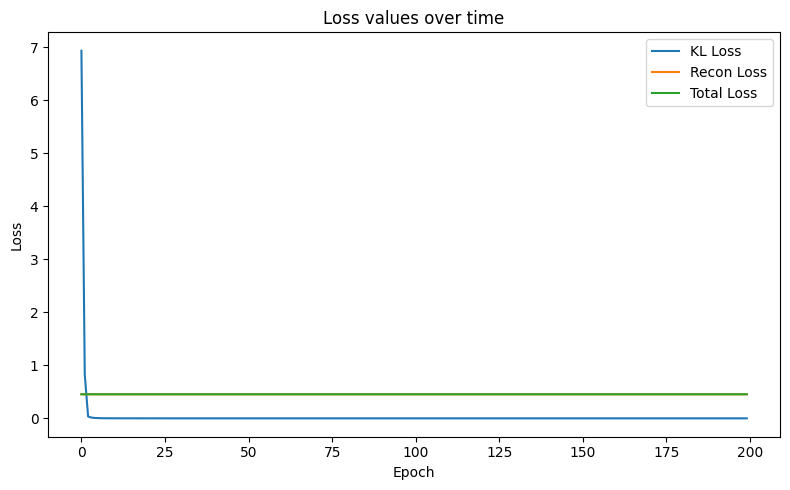

[VGAE] Frozen training


In [121]:
in_dim = real_dataset[0].x.size(1)
hidden_dim = 64
latent_dim = 32

print(f"Using in_dim = {in_dim}, hidden_dim = {hidden_dim}, latent_dim = {latent_dim}")
vgae = build_vgae(in_dim=in_dim, hidden=64, latent=latent_dim)

# 1. Unsupervised pre-train
DiscriminatorVGAE.train_unsupervised(vgae, real_dataset, beta=0.1, device="cuda", warmup_epochs=100)


In [ ]:

# 2. Classifer
discriminator = DiscriminatorVGAE(vgae, latent_dim=32)

plot_tsne(discriminator, real_dataset + fake_dataset)

losses = DiscriminatorVGAE.train_classifier(discriminator, real_dataset + fake_dataset, device="cuda")

plot_tsne(discriminator, real_dataset + fake_dataset)

plt.plot(losses)
plt.title("Classifier BCE")
plt.show()


In [ ]:
# discriminator = build_and_train_discriminator(real_dataset, fake_dataset, device="cuda")